# Calculating and Plotting the Green-house Gas (GHG) Emissions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import seaborn as sns
import copy
from copy import deepcopy
import geopandas as gpd

# Better plots
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 18,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

def weighted_median(data, weights):
    sort_idx = np.argsort(data)
    data = data[sort_idx]
    weights = weights[sort_idx]
    cumsum = np.cumsum(weights)
    cutoff = np.sum(weights) / 2.0
    median = data[cumsum >= cutoff][0]

    return median

def weighted_mean(data, weights):
    mean = np.sum(data * weights) / np.sum(weights)
    return mean

# Load the Dataset

In [44]:
root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data')

data_folder_path_SHCS = os.path.join(root_path, "SHCS-2019", "spss", "spss25")
SHCS_subset = ["annkWh_fp3_BRE", "incAHC", "primFuel_biomass", "la", "fpWghtAHC", "lafpWghtAHC", "L3", "arc_P75std_whd", "FP3mis9010_rrrstidis"]
df_SHCS = pd.read_spss(os.path.join(data_folder_path_SHCS, "shcs2019_dataset.sav"))[SHCS_subset]

def preprocess_df(df):
    ## process str liuke ">=xx or <= xx", extract the number xx from them
    df = df.assign(annkWh_fp3_BRE = df["annkWh_fp3_BRE"].astype("str").str.extract('(\d+)').astype("float"),
                             incAHC = df["incAHC"].astype("str").str.extract('(\d+)').astype("float"),
                   arc_P75std_whd = df["arc_P75std_whd"].astype("str").str.extract('(\d+)').astype("float"))

    # drop household with no income data
    df = df.dropna(subset = ["incAHC"])
    return df
df_SHCS = preprocess_df(df_SHCS)

df_SHCS_3y = []
for year in [2017, 2018, 2019]:
    data_folder_path_SHCS = os.path.join(root_path, "SHCS-2019", "spss", "spss25")
    # load and preprocess
    df_SHCS_3y.append(preprocess_df(pd.read_spss(os.path.join(data_folder_path_SHCS, f"shcs{year}_dataset.sav"))[SHCS_subset]))

df_SHCS_3y = pd.concat(df_SHCS_3y)

Scot_nongas_rate = df_SHCS[df_SHCS["primFuel_biomass"] != "Mains gas"]['fpWghtAHC'].sum() / df_SHCS['fpWghtAHC'].sum()
Scot_nongas_rate

0.19188075461140766

In [45]:
# load the dataframe
data_folder_path_EHS_FP = os.path.join(root_path, "EHS-FuelPoverty-2019", "spss", "spss25")
subset = ["WHDBroad", "fuelexpn", "wathcost", "spahcost", "litecost", "cookcost", "fpfullinc", "HousingCosts", "Mainfueltype", "gorehs", "aagph1819", "Ongas", "CentralHeating"]
df_EHS_FP = pd.read_csv(os.path.join(root_path, "df_EHS_FP_processed.csv"))
Eng_nongas_rate = df_EHS_FP[df_EHS_FP["Mainfueltype"] != "gas"]['aagph1819'].sum() / df_EHS_FP['aagph1819'].sum()
Eng_nongas_rate

0.1287577998771097

In [ ]:
### Number of household

root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data')
look_up_df = pd.read_csv(os.path.join(root_path, "Ward_to_Local_Authority_District_to_County_to_Region_to_Country_(December_2018)_Lookup_in_United_Kingdom_.csv"))[["LAD18CD", "LAD18NM"]]
look_up_df.drop_duplicates(subset=["LAD18CD"], inplace=True)
look_up_df = look_up_df[look_up_df["LAD18CD"].str.contains("S")].reset_index(drop=True)
scot_name2code_dict = {row["LAD18NM"].lower():row["LAD18CD"] for idx, row in look_up_df.iterrows()}
scot_name2code_dict["edinburgh, city of"] = scot_name2code_dict.pop("city of edinburgh")
scot_name2code_dict["glasgow city"] = "S12000049"
scot_name2code_dict["north lanarkshire"] = "S12000050"

census_root_path = os.path.join(os.path.dirname(os.getcwd()), "FuelPoverty_data", "Census")
Scotland_la_household_no = np.load(os.path.join(census_root_path, "scot_la2householdno_dict.npy"), allow_pickle=True).item()

Scotland_la_household_no = {la:Scotland_la_household_no[scot_name2code_dict[la]] for la in scot_name2code_dict.keys()}
Scotland_la_household_no

In [47]:
Scotland_household_no = 2372777
England_household_no = 23436085

### Energy on Heating kW/year
Scotland_mean_heat = 23613.471203792094
England_mean_heat = 15578.882071970696

### Carbon Intensity Data
Data source is [UK Government Report](https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2020)
Biomass is the average of seasoned wood and pellets, which is the same assumption as in Fuel poverty estimations.
Note that the Biomass CO2 factor has taken into account the absorbation of CO2 during the rapid growth of biomass.

All of the numbers below has takend into account the efficiency, so they are essensially KgCO2e/KWh heat

In [48]:
# Carbon Intensity Data

### below is the CO2e conversion factors (Kg/kWh) for different fuels after the consideration of boiler efficiency
gas_co2_factor = 0.18387  / 0.9
###  we want to isolate gas emission
gas_co2_factor = 0
coal_co2_factor = 0.34462 / 0.75
oil_co2_factor = 0.24666 /0.9
LPG_co2_factor = 0.21448 /0.9
Biomass_factor = 0.01545/0.85
# the electricity carbon intensity (gCO2e/kWh) 
electricity_co2_factor_worst = np.array([233.14])/1000

HP_co2_factor_worst = electricity_co2_factor_worst/3

In [49]:
england_other_fuel_composition = pd.read_csv(os.path.join(root_path, "Census", "2021Census England Fuel Composition for Other Option (Processed)"), index_col=0)
# make it percentage data
england_other_fuel_composition["Observation"] = england_other_fuel_composition["Observation"]/england_other_fuel_composition["Observation"].sum()
## This is for the 'other' option in England FP data
other_co2_factor = england_other_fuel_composition.loc["Tank or bottled gas only"].item()*LPG_co2_factor + england_other_fuel_composition.loc["Oil only"].item()*oil_co2_factor + england_other_fuel_composition.loc["Wood only"].item()*Biomass_factor + england_other_fuel_composition.loc["Solid fuel only"].item()*coal_co2_factor

# Calculate GHG Emission From Residential Heating

In [50]:
### Calculate GHG Emission for Scotland
df_SHCS_GHG = df_SHCS[["la", "primFuel_biomass", "fpWghtAHC", "lafpWghtAHC"]].copy()
df_SHCS_GHG["heat energy"] = df_SHCS["annkWh_fp3_BRE"].copy() * 0.87

df_SHCS_GHG_3y = df_SHCS_3y[["la", "primFuel_biomass", "fpWghtAHC", "lafpWghtAHC"]].copy()
df_SHCS_GHG_3y["heat energy"] = df_SHCS_3y["annkWh_fp3_BRE"].copy() * 0.87

def Scot_annual_CO2(elec_co2_factor, HP_co2_factor, df_SHCS_GHG, la = False):
    df_SHCS_GHG["GHG (kg)"] = None
    for option in df_SHCS_GHG["primFuel_biomass"].unique():
        if option in ["Mains gas", "Communal Heating"]:
            co2_factor = gas_co2_factor
        elif option == "Electricity":
            co2_factor = elec_co2_factor
        elif option == "Oil":
            co2_factor = oil_co2_factor
        elif option == "Solid mineral fuel":
            co2_factor = coal_co2_factor
        elif option == "LPG bulk or bottled":
            co2_factor = LPG_co2_factor
        elif option == "Biomass":
            co2_factor = Biomass_factor
        elif option == "HP":
            co2_factor = HP_co2_factor
        else:
            raise ValueError("Check your option")

        df_SHCS_GHG.loc[df_SHCS_GHG["primFuel_biomass"] == option, "GHG (kg)"] = df_SHCS_GHG.loc[df_SHCS_GHG["primFuel_biomass"] == option, "heat energy"] * co2_factor

    if la:
        res = {}
        la_list = df_SHCS["la"].unique()
        for la_name in la_list:
            df_SHCS_GHG_sub =df_SHCS_GHG[df_SHCS_GHG["la"] == la_name]
            tot_GHG_la = np.sum(df_SHCS_GHG_sub["GHG (kg)"].values * df_SHCS_GHG_sub["lafpWghtAHC"].values)
            # scale based on the SScotland's total number of households
            tot_GHG_la = tot_GHG_la * Scotland_la_household_no[la_name.lower()] / df_SHCS_GHG_sub["lafpWghtAHC"].sum()
            res[la_name] = tot_GHG_la

        return res

    df_SHCS_GHG["GHG (kg)"] = df_SHCS_GHG["GHG (kg)"].astype("float")

    tot_GHG = np.sum(df_SHCS_GHG["GHG (kg)"].values * df_SHCS_GHG["fpWghtAHC"].values)
    # scale based on the SScotland's total number of households
    tot_GHG = tot_GHG * Scotland_household_no / df_SHCS_GHG["fpWghtAHC"].sum()
    return tot_GHG

Scotland_GHG_beforeHP = []
for i in range(len(electricity_co2_factor_worst)):
    elec_co2_factor = electricity_co2_factor_worst[i]
    HP_co2_factor = HP_co2_factor_worst[i]

    tot_GHG = Scot_annual_CO2(elec_co2_factor, HP_co2_factor, df_SHCS_GHG.copy())
    Scotland_GHG_beforeHP.append(tot_GHG)

Scotland_GHG_beforeHP = np.array(Scotland_GHG_beforeHP)

df_SHCS_GHG_HP = df_SHCS_GHG.copy()
df_SHCS_GHG_HP["primFuel_biomass"] = df_SHCS_GHG_HP["primFuel_biomass"].astype("str")
df_SHCS_GHG_HP.loc[df_SHCS_GHG_HP["primFuel_biomass"] != "Mains gas", "primFuel_biomass"] = "HP"

Scotland_GHG_afterHP = []
for i in range(len(electricity_co2_factor_worst)):
    elec_co2_factor = electricity_co2_factor_worst[i]
    HP_co2_factor = HP_co2_factor_worst[i]

    tot_GHG = Scot_annual_CO2(elec_co2_factor, HP_co2_factor, df_SHCS_GHG_HP.copy())
    Scotland_GHG_afterHP.append(tot_GHG)

Scotland_GHG_afterHP = np.array(Scotland_GHG_afterHP)

In [51]:
### Calculate GHG Emission for England
df_EHS_GHG = df_EHS_FP[["gorehs", "Mainfueltype", "aagph1819", "heat_energy", "other_energy"]].copy()

def Eng_annual_CO2(elec_co2_factor, HP_co2_factor, df_EHS_GHG, la = False):
    df_EHS_GHG["GHG (kg)"] = None
    for option in df_EHS_GHG["Mainfueltype"].unique():
        if option in ["gas"]:
            co2_factor = gas_co2_factor
        elif option == "electricity":
            co2_factor = elec_co2_factor
        elif option == "other":
            co2_factor = other_co2_factor
        elif option == "HP":
            co2_factor = HP_co2_factor
        else:
            raise ValueError("Check your option")

        df_EHS_GHG.loc[df_EHS_GHG["Mainfueltype"] == option, "GHG (kg)"] = df_EHS_GHG.loc[df_EHS_GHG["Mainfueltype"] == option, "heat_energy"] * co2_factor

    if la:
        res = {}
        reg_list = df_EHS_GHG["gorehs"].unique()
        scaling_factor = England_household_no / df_EHS_GHG["aagph1819"].sum()
        for reg_name in reg_list:
            df_EHS_GHG_sub =df_EHS_GHG[df_EHS_GHG["gorehs"] == reg_name]
            tot_GHG_reg = np.sum(df_EHS_GHG_sub["GHG (kg)"].values * df_EHS_GHG_sub["aagph1819"].values)
            # scale based on the SScotland's total number of households
            tot_GHG_reg = tot_GHG_reg * scaling_factor
            res[reg_name] = tot_GHG_reg

        return res

    tot_GHG = np.sum(df_EHS_GHG["GHG (kg)"].values * df_EHS_GHG["aagph1819"].values)
    # scale based on the SScotland's total number of households
    tot_GHG = tot_GHG * England_household_no / df_EHS_GHG["aagph1819"].sum()
    return tot_GHG

England_GHG_beforeHP = []
for i in range(len(electricity_co2_factor_worst)):
    elec_co2_factor = electricity_co2_factor_worst[i]
    HP_co2_factor = HP_co2_factor_worst[i]

    tot_GHG = Eng_annual_CO2(elec_co2_factor, HP_co2_factor, df_EHS_GHG.copy())
    England_GHG_beforeHP.append(tot_GHG)
England_GHG_beforeHP = np.array(England_GHG_beforeHP)

df_EHS_GHG_HP = df_EHS_GHG.copy()
df_EHS_GHG_HP.loc[df_EHS_GHG_HP["Mainfueltype"] != "gas", "Mainfueltype"] = "HP"

England_GHG_afterHP = []
for i in range(len(electricity_co2_factor_worst)):
    elec_co2_factor = electricity_co2_factor_worst[i]
    HP_co2_factor = HP_co2_factor_worst[i]

    tot_GHG = Eng_annual_CO2(elec_co2_factor, HP_co2_factor, df_EHS_GHG_HP.copy())
    England_GHG_afterHP.append(tot_GHG)

England_GHG_afterHP = np.array(England_GHG_afterHP)

In [55]:
Scot_elec_rate = df_SHCS[df_SHCS["primFuel_biomass"] == "Electricity"]['fpWghtAHC'].sum() / df_SHCS['fpWghtAHC'].sum()
Eng_elec_rate = df_EHS_FP[df_EHS_FP["Mainfueltype"] == "electricity"]['aagph1819'].sum() / df_EHS_FP['aagph1819'].sum()

print(f"For Scotland, its nongas rate is {Scot_nongas_rate} and its electric heater rate is {Scot_elec_rate}")
print(f"For England, its nongas rate is {Eng_nongas_rate} and its electric heater rate is {Eng_elec_rate}")

For Scotland, its nongas rate is 0.19188075461140766 and its electric heater rate is 0.10445758936679374
For England, its nongas rate is 0.1287577998771097 and its electric heater rate is 0.07341252978277052


# GHG Emission For LA/Reg

## Scotland

In [56]:
# drop ambiguious heating option
df_SHCS_GHG_3y = df_SHCS_GHG_3y[df_SHCS_GHG_3y['primFuel_biomass'] != "N/A or Unobtainable"]

elec_co2_factor = electricity_co2_factor_worst[0]
HP_co2_factor = HP_co2_factor_worst[0]
Scot_laGHG_dict = Scot_annual_CO2(elec_co2_factor, HP_co2_factor, df_SHCS_GHG_3y.copy(), la=True)

In [57]:
df_SHCS_GHG_HP_3y = df_SHCS_GHG_3y.copy()
df_SHCS_GHG_HP_3y["primFuel_biomass"] = df_SHCS_GHG_HP_3y["primFuel_biomass"].astype("str")
df_SHCS_GHG_HP_3y.loc[df_SHCS_GHG_HP_3y["primFuel_biomass"] != "Mains gas", "primFuel_biomass"] = "HP"

Scot_laGHG_HP_dict = Scot_annual_CO2(elec_co2_factor, HP_co2_factor, df_SHCS_GHG_HP_3y.copy(), la=True)

In [58]:
## get the reduction rate
Scot_GHG_reduction_rate_dict = {}
for la_name in Scot_laGHG_dict.keys():
    reduction_rate = (Scot_laGHG_dict[la_name] - Scot_laGHG_HP_dict[la_name]) / Scot_laGHG_dict[la_name]
    Scot_GHG_reduction_rate_dict[la_name] = reduction_rate

np.save(os.path.join(root_path, "Scot_GHG_reduction_rate_dict.npy"),Scot_GHG_reduction_rate_dict, allow_pickle=True)

## England

In [59]:
Eng_regGHG_dict = Eng_annual_CO2(elec_co2_factor, HP_co2_factor, df_EHS_GHG.copy(), la = True)
Eng_regGHG_HP_dict = Eng_annual_CO2(elec_co2_factor, HP_co2_factor, df_EHS_GHG_HP.copy(), la = True)

## get the reduction rate
Eng_GHG_reduction_rate_dict = {}
for reg_name in Eng_regGHG_dict.keys():
    reduction_rate = (Eng_regGHG_dict[reg_name] - Eng_regGHG_HP_dict[reg_name]) / Eng_regGHG_dict[reg_name]
    Eng_GHG_reduction_rate_dict[reg_name] = reduction_rate

GHG_reduction_rate_dict = {**Eng_GHG_reduction_rate_dict, **Scot_GHG_reduction_rate_dict}

In [60]:
np.save(os.path.join(root_path, "GHG_reduction_rate_dict.npy"),GHG_reduction_rate_dict, allow_pickle=True)

In [61]:
GHG_reduction_rate_dict

{'Yorkshire and the Humber': 0.6954654542890757,
 'West Midlands': 0.6935197477775759,
 'South East': 0.6898967606266391,
 'South West': 0.6935119348161346,
 'East Midlands': 0.6929511546509225,
 'North East': 0.6929360671028026,
 'London': 0.6829001321493317,
 'North West': 0.6892477154948933,
 'East': 0.6964487617941924,
 'Edinburgh, City of': 0.6405329398080319,
 'North Ayrshire': 0.6882242440126619,
 'East Ayrshire': 0.6605564680912677,
 'North Lanarkshire': 0.6686828272879732,
 'Perth and Kinross': 0.676723635822013,
 'East Lothian': 0.6534015603231912,
 'Aberdeen City': 0.5052418567089658,
 'Glasgow City': 0.5929596926745694,
 'East Renfrewshire': 0.6304003912458803,
 'Highland': 0.684691483234857,
 'Argyll and Bute': 0.6942479729742628,
 'Na h-Eileanan Siar': 0.7040245978676097,
 'Dumfries and Galloway': 0.6998537757537884,
 'Orkney Islands': 0.6983370963741831,
 'Dundee City': 0.6139428806212023,
 'Shetland Islands': 0.6787665078087786,
 'East Dunbartonshire': 0.661025060713846

{'whiskers': [<matplotlib.lines.Line2D at 0x28ca836dd00>,
 'caps': [<matplotlib.lines.Line2D at 0x28ca67f1280>,
 'boxes': [<matplotlib.lines.Line2D at 0x28ca836da60>],
 'medians': [<matplotlib.lines.Line2D at 0x28ca67f17c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x28ca67f1a60>],
 'means': []}

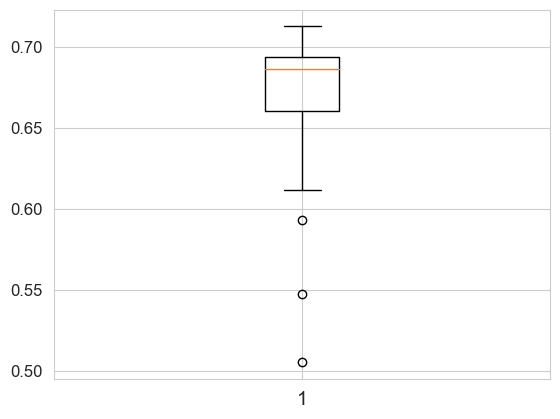

In [62]:
plt.boxplot(GHG_reduction_rate_dict.values())

In [73]:
a = np.array(list(GHG_reduction_rate_dict.values()))
np.sum(a>=0.6) / len(a)

0.926829268292683

In [72]:
All_la_GHG_dict = {**Scot_laGHG_dict, **Eng_regGHG_dict}
All_la_GHG_HP_dict = {**Scot_laGHG_HP_dict, **Eng_regGHG_HP_dict}

np.save(os.path.join(root_path, "All_la_GHG_dict.npy"),All_la_GHG_dict, allow_pickle=True)
np.save(os.path.join(root_path, "All_la_GHG_HP_dict.npy"),All_la_GHG_HP_dict, allow_pickle=True)

In [67]:
sum(All_la_GHG_dict.values())

12440592500.323713

In [70]:
sum(All_la_GHG_HP_dict.values()) / 1e9

3.860775636462373